<a href="https://colab.research.google.com/github/coleb9/Time-Series-Project/blob/main/Time_Series_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving time_series_60min_singleindex.csv to time_series_60min_singleindex.csv


## Data Pre-Processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


#### Load & Clean Data


In [2]:
df = pd.read_csv("time_series_60min_singleindex.csv")

# Define target column
target_col = "DE_load_actual_entsoe_transparency"

# Select only the German columns we need
columns = [
    "utc_timestamp",
    "DE_load_actual_entsoe_transparency",
    "DE_wind_onshore_generation_actual",
    "DE_solar_generation_actual"
]

df = df[columns]

# Convert timestamp to proper datetime format
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])

# Set it as the index
df = df.set_index('utc_timestamp')

# Sort by time just to be safe
df = df.sort_index()


# Check how many missing values exist
df.isna().sum()

# Ensure all numeric columns are actually numeric (required for interpolation)
df = df.apply(pd.to_numeric, errors='coerce')

# Interpolate missing values based on time
df = df.interpolate(method='time').ffill().bfill()

# Create time-based features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek    # Monday=0, Sunday=6
df['month'] = df.index.month

#### Split Data (BEFORE SCALING)

In [3]:
# We define the split points using the raw data length
n = len(df)
train_size = int(n * 0.70)
val_size = int(n * 0.15)

# Split the raw DataFrame
train_df = df.iloc[:train_size]
val_df = df.iloc[train_size : train_size + val_size]
test_df = df.iloc[train_size + val_size :]

print(f"Data Split: Train ({len(train_df)}), Val ({len(val_df)}), Test ({len(test_df)})")

Data Split: Train (35280), Val (7560), Test (7561)


##### Analysis and Visualization

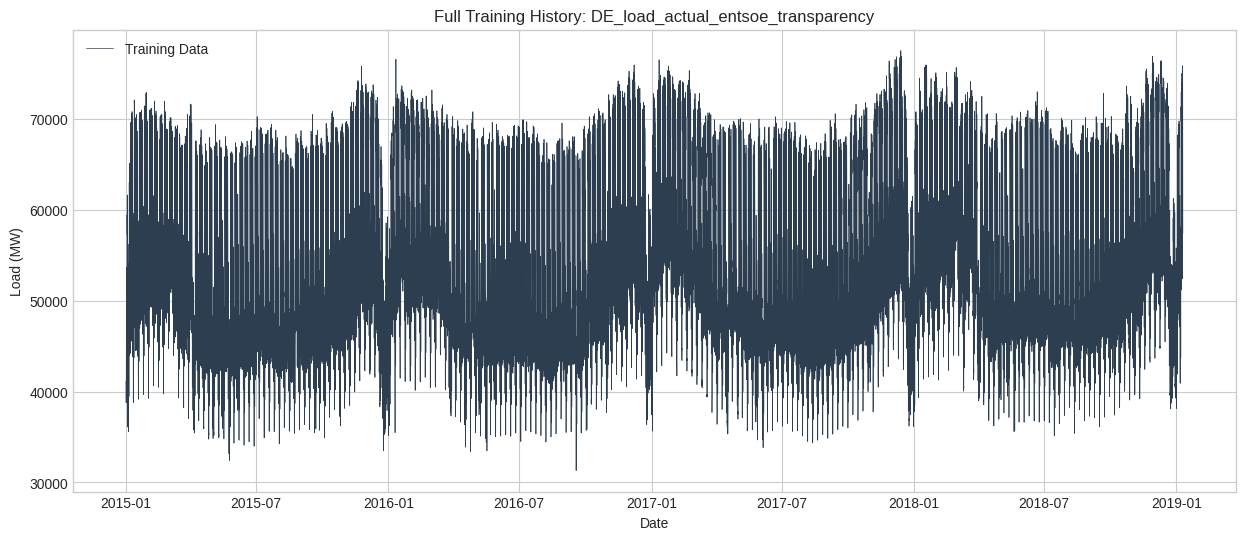

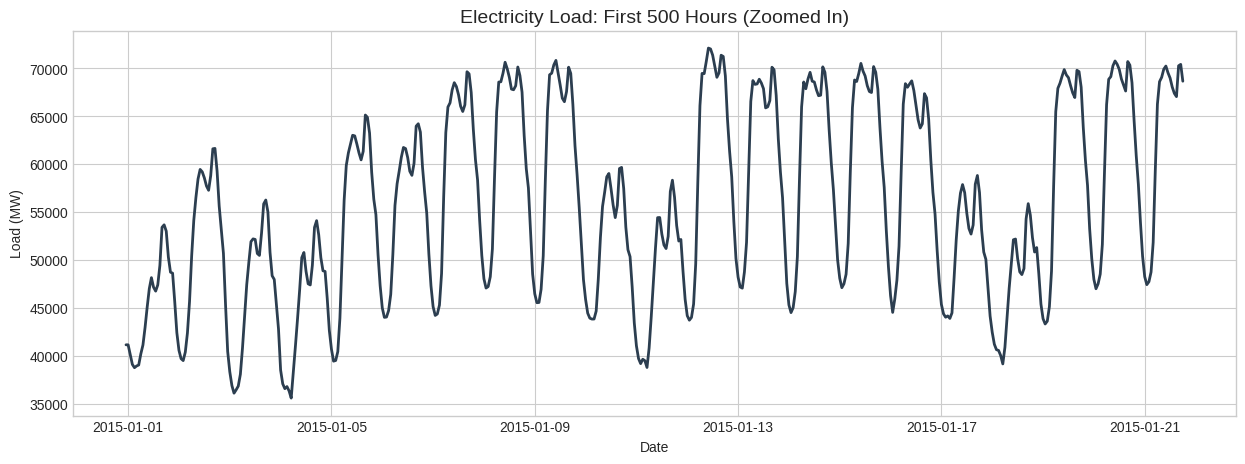

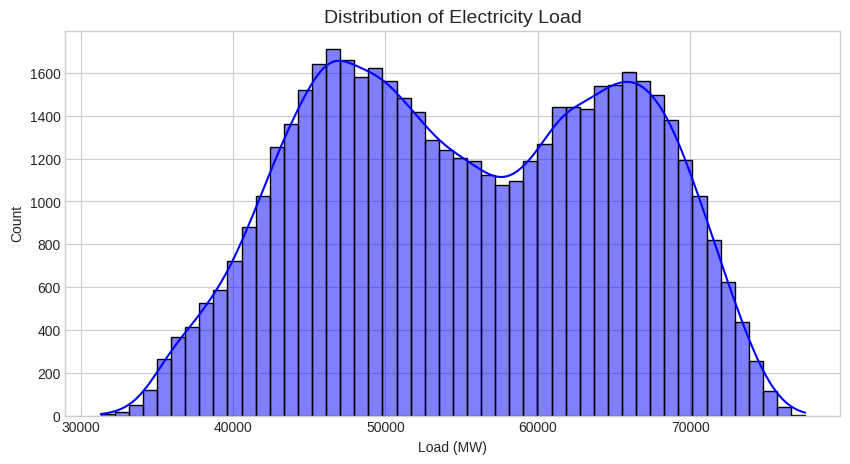

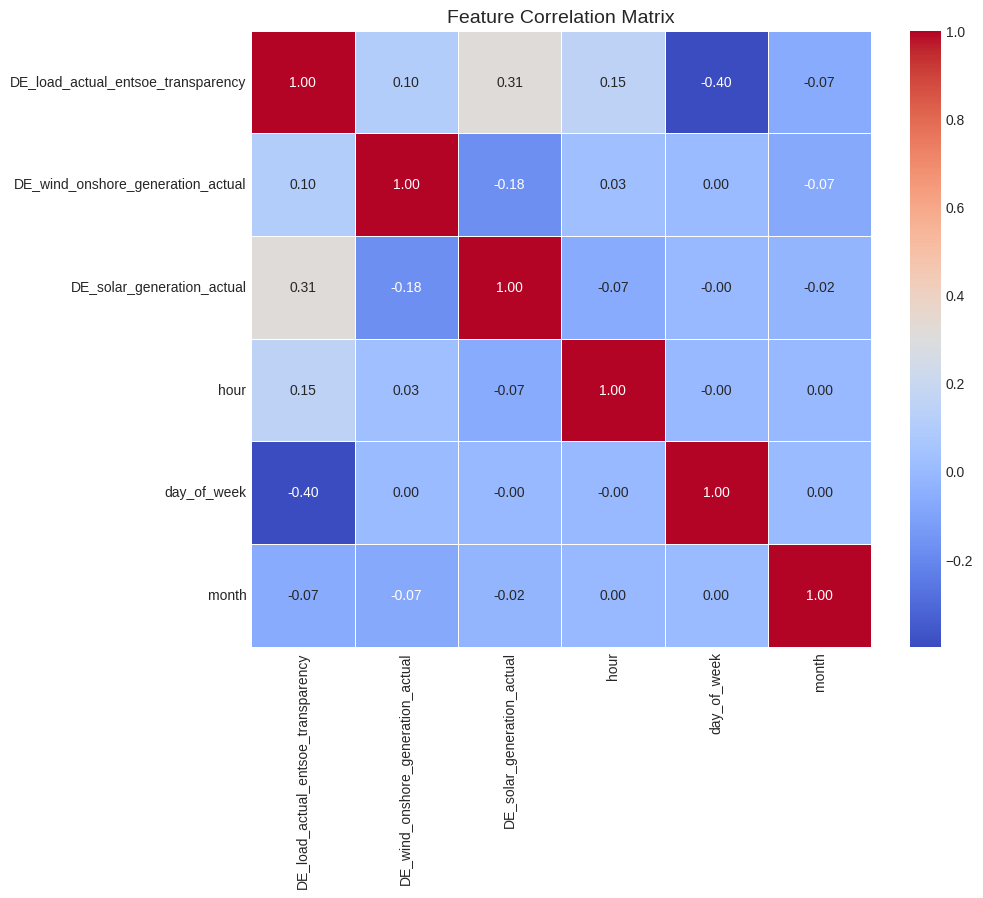

/tmp/ipython-input-2791306625.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hour', y='DE_load_actual_entsoe_transparency', data=df, palette="Blues")


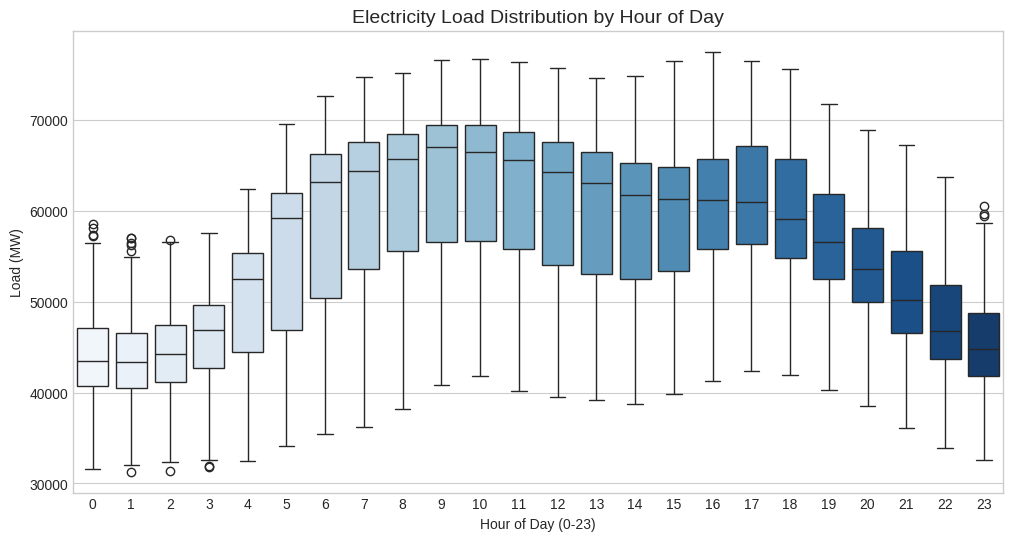


--- BEGINNING SEASONALITY ANALYSIS ---
Using Raw Training Data (in MW) for interpretability.



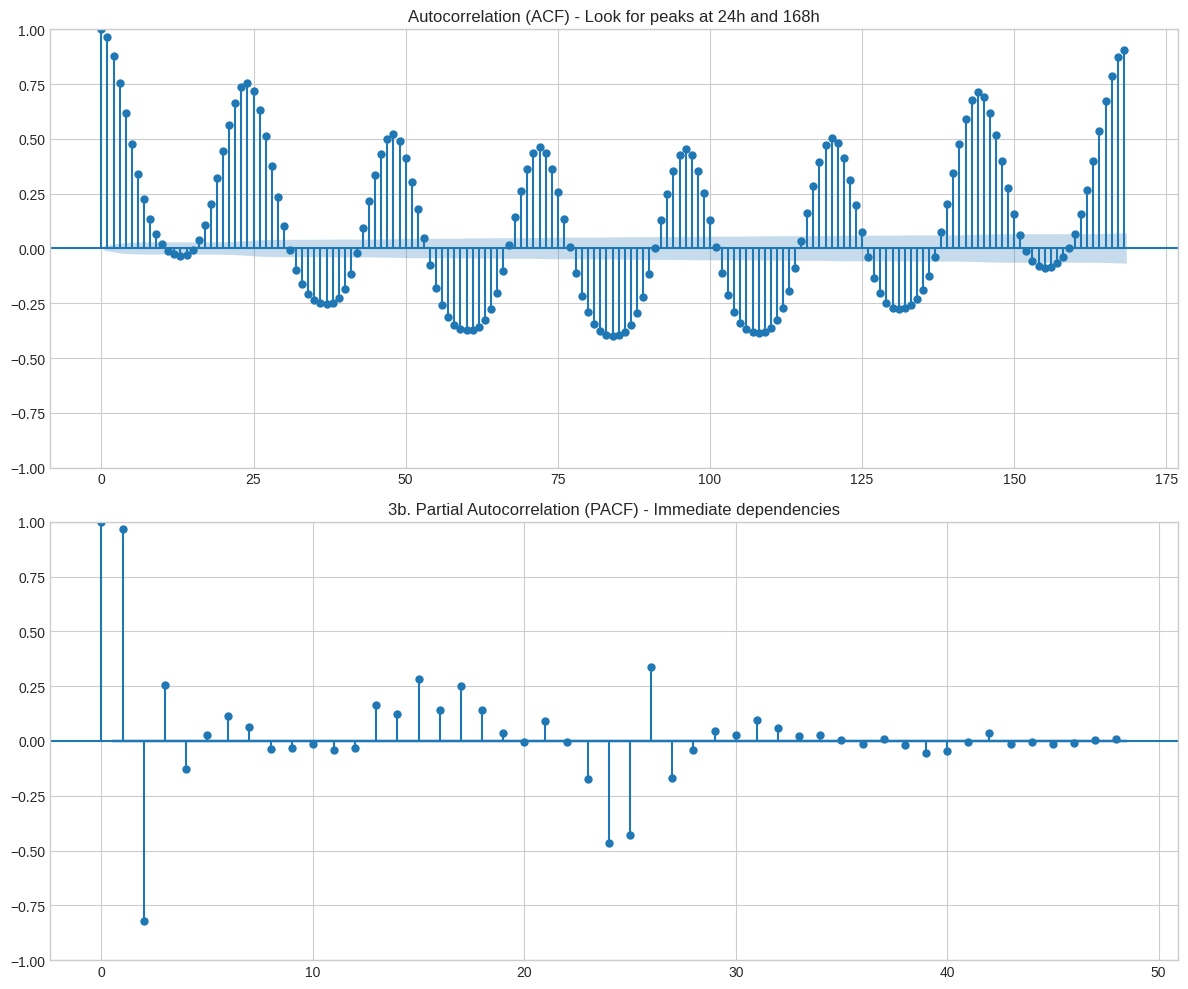

Generating Seasonal Decomposition...


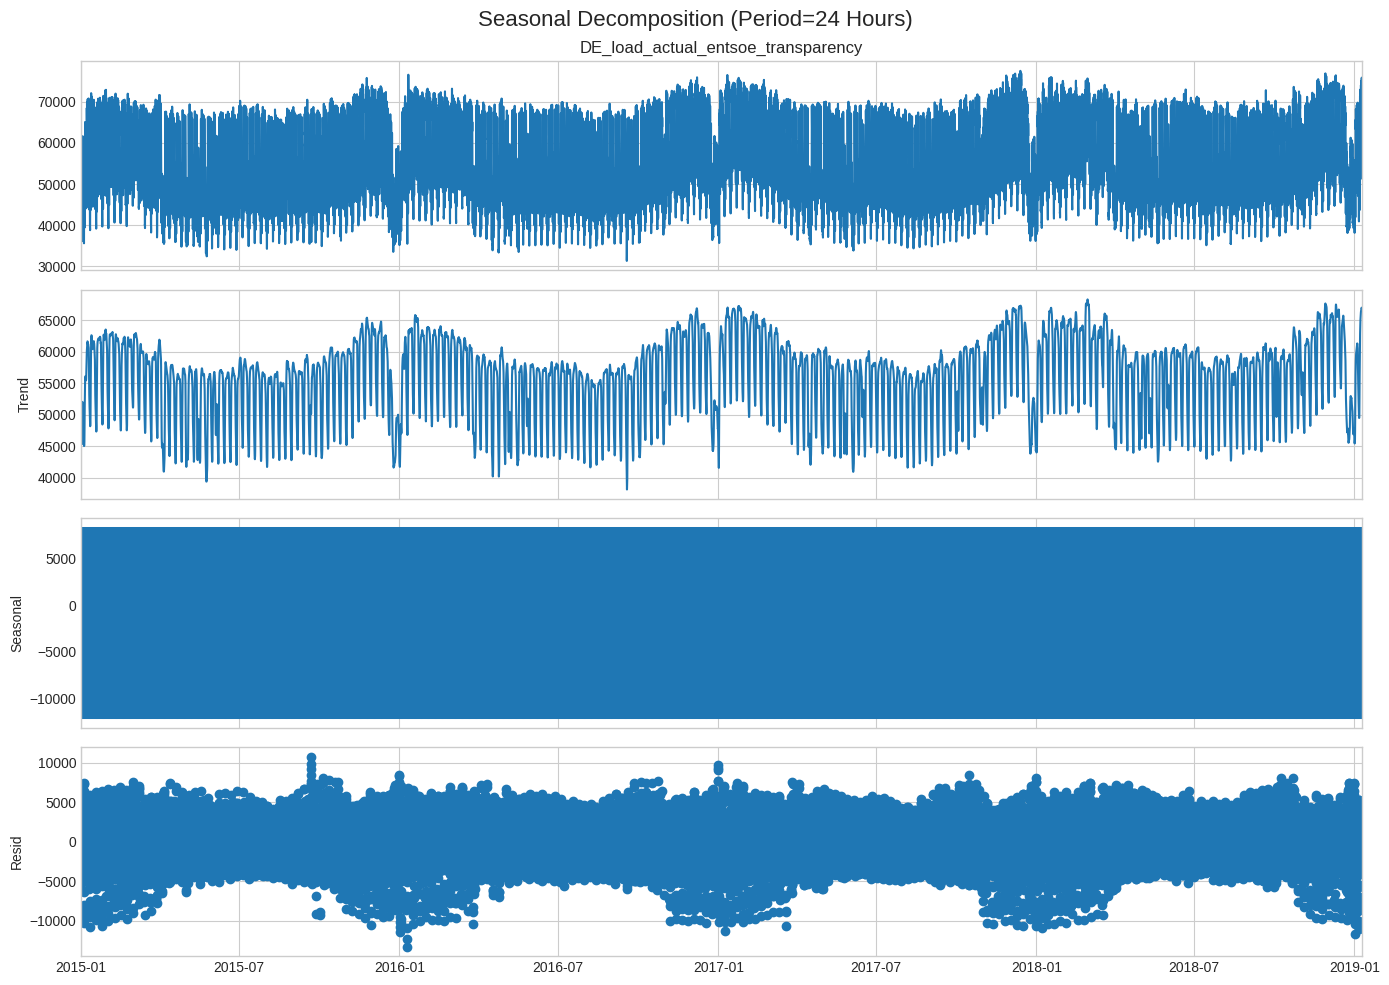


--- Augmented Dickey-Fuller Test Results ---
Test Statistic                   -22.872580
p-value                            0.000000
#Lags Used                        53.000000
Number of Observations Used    35226.000000
Critical Value (1%)               -3.430536
Critical Value (5%)               -2.861622
Critical Value (10%)              -2.566814
dtype: float64
Conclusion: Data is STATIONARY (Reject Null Hypothesis)


In [ ]:
# Trend over full history
plt.figure(figsize=(15, 6))
plt.plot(train_df.index, train_df[target_col], label='Training Data', linewidth=0.5, color='#2c3e50')
plt.title(f'Full Training History: {target_col}')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.legend()
plt.show()

# Plot - Target Variable Over Time
plt.figure(figsize=(15, 5))
# Plot just the first 500 hours to make the pattern visible
plt.plot(df.index[:500], df['DE_load_actual_entsoe_transparency'][:500], color='#2c3e50', linewidth=2)
plt.title('Electricity Load: First 500 Hours (Zoomed In)', fontsize=14)
plt.ylabel('Load (MW)')
plt.xlabel('Date')
plt.show()

# Distribution of the Target (Normality Check)
# Justifies using StandardScaler. If this looks like a Bell Curve, Standard Scaling is the mathematically correct choice.
plt.figure(figsize=(10, 5))
sns.histplot(df['DE_load_actual_entsoe_transparency'], kde=True, color='blue', bins=50)
plt.title('Distribution of Electricity Load', fontsize=14)
plt.xlabel('Load (MW)')
plt.show()

# Feature Correlation Heatmap
plt.figure(figsize=(10, 8))
# Calculate correlation matrix
corr = df.corr()
# Plot heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=14)
plt.show()

# Boxplot by Hour of Day
# Shows the "Shape" of a typical day.
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='DE_load_actual_entsoe_transparency', data=df, palette="Blues")
plt.title('Electricity Load Distribution by Hour of Day', fontsize=14)
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Load (MW)')
plt.show()

# Seasonarity Analysis (on train data)
print("\n--- BEGINNING SEASONALITY ANALYSIS ---")
print("Using Raw Training Data (in MW) for interpretability.\n")

# ACF and PACF Plots
# We check for correlations up to 1 week (168 hours)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

plot_acf(train_df[target_col], lags=168, ax=ax1, title="Autocorrelation (ACF) - Look for peaks at 24h and 168h")
plot_pacf(train_df[target_col], lags=48, ax=ax2, method='ywm', title="3b. Partial Autocorrelation (PACF) - Immediate dependencies")

plt.tight_layout()
plt.show()

# Seasonal Decomposition
# We use period=24 to extract the Daily Cycle
print("Generating Seasonal Decomposition...")
decomposition = seasonal_decompose(train_df[target_col], model='additive', period=24)

fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.suptitle('Seasonal Decomposition (Period=24 Hours)', fontsize=16)
plt.tight_layout()
plt.show()

# Stationarity Test (ADF)
def adf_test(series):
    print(f"\n--- Augmented Dickey-Fuller Test Results ---")
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dftest[1] <= 0.05:
        print("Conclusion: Data is STATIONARY (Reject Null Hypothesis)")
    else:
        print("Conclusion: Data is NON-STATIONARY (Fail to Reject Null Hypothesis)")
        print("Suggestion: Consider differencing if training accuracy is low.")

adf_test(train_df[target_col])

In [4]:
#Check for outliers to determine what type of Scaling we should use
# target column
data = df['DE_load_actual_entsoe_transparency']

# If Z-Score outliers are > 0%, MinMax scaling might squash our 'normal' data
# Any point more than 3 Standard Deviations from the mean is considered an outlier
mean = np.mean(data)
std = np.std(data)
z_scores = (data - mean) / std
outliers_z = np.sum(np.abs(z_scores) > 3)
pct_z = (outliers_z / len(data)) * 100

print(f"Total Data Points: {len(data)}")
print(f"Outliers (Z-Score > 3): {outliers_z} ({pct_z:.2f}%)")

Total Data Points: 50401
Outliers (Z-Score > 3): 0 (0.00%)


In [5]:
# SCALING (FIT ON TRAIN ONLY)
# Even though there are no outliers, we will use standard scalar to make the model
#robust for future unexpected outliers and to center the data for Relu activation function
scaler = StandardScaler()

# FIT only on Training data
scaler.fit(train_df)

# TRANSFORM all sets using the training statistics
train_scaled = scaler.transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)


In [6]:
# CREATE WINDOWS
def create_sliding_windows(data, window_size, target_idx):
    X_list, y_list = [], []
    for i in range(len(data) - window_size):
        # Input: Past 'window_size' steps
        X_list.append(data[i : i + window_size])
        # Target: The very next step (at index i + window_size)
        y_list.append(data[i + window_size, target_idx])
    return np.array(X_list), np.array(y_list)

# Define params
WINDOW_SIZE = 24
TARGET_COL_NAME = "DE_load_actual_entsoe_transparency"
target_idx = df.columns.get_loc(TARGET_COL_NAME)

# Create sets
X_train, y_train = create_sliding_windows(train_scaled, WINDOW_SIZE, target_idx)
X_val, y_val = create_sliding_windows(val_scaled, WINDOW_SIZE, target_idx)
X_test, y_test = create_sliding_windows(test_scaled, WINDOW_SIZE, target_idx)

print(f"Train shape: {X_train.shape}")
print(f"Test shape:  {X_test.shape}")

Train shape: (35256, 24, 6)
Test shape:  (7537, 24, 6)


# LSTM Model

In [ ]:
# ==== Baseline LSTM Model & Training ====

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Input shape: (time_steps, num_features)
input_shape = X_train.shape[1:]  # (WINDOW_SIZE, num_features)

baseline_lstm = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(32),
    layers.Dropout(0.2),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

baseline_lstm.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse"
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history_lstm = baseline_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)


X_train shape: (35256, 24, 6)
y_train shape: (35256,)
Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - loss: 0.2223 - val_loss: 0.0251
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - loss: 0.0382 - val_loss: 0.0200
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 0.0271 - val_loss: 0.0156
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - loss: 0.0210 - val_loss: 0.0147
Epoch 5/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - loss: 0.0188 - val_loss: 0.0133
Epoch 6/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - loss: 0.0162 - val_loss: 0.0166
Epoch 7/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - loss: 0.0143 - val_loss: 0.0134
Epoch 8/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - loss: 0.0131 - val_loss: 0.0131
Epoch 9/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - loss: 0.0121 - val_loss: 0.0143
Epoch 10/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 0.0108 - val_loss: 0.0193
Epoch 11/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - loss: 0.

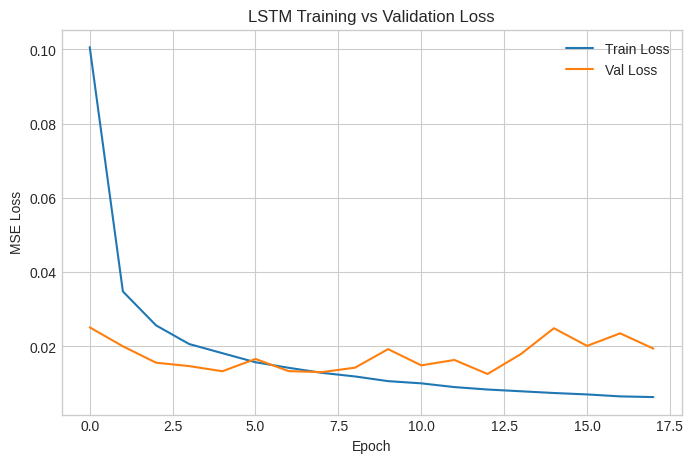

236/236 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step
Test MAE (MW):  959.13
Test RMSE (MW): 1200.38
Test RMSE (scaled targets): 0.1196


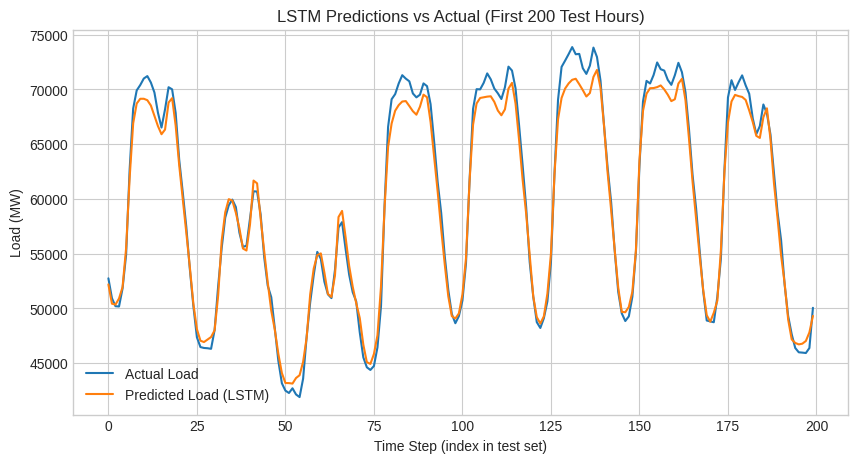

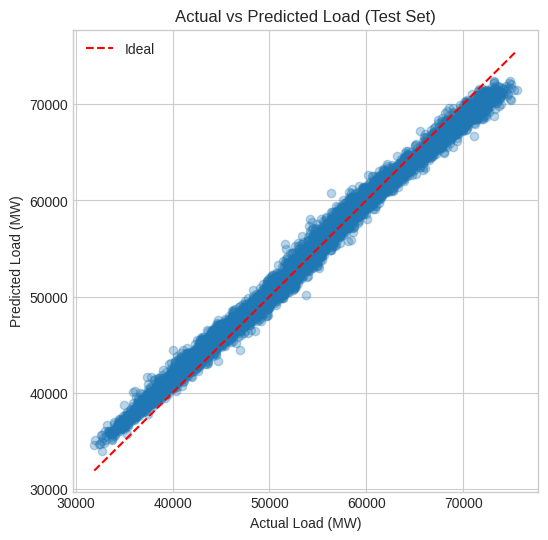

In [ ]:
# ==== Evaluation, Inverse Scaling, and Plots ====

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1) Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history_lstm.history["loss"], label="Train Loss")
plt.plot(history_lstm.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("LSTM Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# 2) Helper: inverse-scale the load using the StandardScaler fit on train_df
def inverse_scale_load(y_scaled, scaler, target_idx):
    """
    y_scaled: 1D array of scaled load values
    scaler: fitted StandardScaler used in preprocessing
    target_idx: column index of the load in the original feature set
    """
    y_scaled = np.asarray(y_scaled).reshape(-1)
    zeros = np.zeros((len(y_scaled), scaler.n_features_in_))
    zeros[:, target_idx] = y_scaled
    inv = scaler.inverse_transform(zeros)
    return inv[:, target_idx]

# 3) Predictions on the test set
y_pred_scaled = baseline_lstm.predict(X_test).reshape(-1)

# 4) Inverse scale to MW
y_test_inv = inverse_scale_load(y_test, scaler, target_idx)
y_pred_inv = inverse_scale_load(y_pred_scaled, scaler, target_idx)

# 5) Metrics in original units (MW)
mae_mw = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_mw = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"Test MAE (MW):  {mae_mw:.2f}")
print(f"Test RMSE (MW): {rmse_mw:.2f}")

# Optional: also look at scaled RMSE if you want
test_mse_scaled = baseline_lstm.evaluate(X_test, y_test, verbose=0)
test_rmse_scaled = np.sqrt(test_mse_scaled)
print(f"Test RMSE (scaled targets): {test_rmse_scaled:.4f}")

# 6) Plot a chunk of predictions vs actual (time series view)
N = 200  # number of hours to plot
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv[:N], label="Actual Load")
plt.plot(y_pred_inv[:N], label="Predicted Load (LSTM)")
plt.xlabel("Time Step (index in test set)")
plt.ylabel("Load (MW)")
plt.title("LSTM Predictions vs Actual (First 200 Test Hours)")
plt.legend()
plt.grid(True)
plt.show()

# 7) Scatter plot: predicted vs actual
plt.figure(figsize=(6, 6))
plt.scatter(y_test_inv, y_pred_inv, alpha=0.3)
plt.xlabel("Actual Load (MW)")
plt.ylabel("Predicted Load (MW)")
plt.title("Actual vs Predicted Load (Test Set)")
min_val = min(y_test_inv.min(), y_pred_inv.min())
max_val = max(y_test_inv.max(), y_pred_inv.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--", label="Ideal")
plt.legend()
plt.grid(True)
plt.show()



Training config: L32_lr1e-3
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

Training config: L64_lr1e-3
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

Training config: L64_lr5e-4
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

Training config: L128_lr1e-3
236/236 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


,name,units,lr,batch_size,best_val_loss,val_rmse_scaled,epochs_run
0,L32_lr1e-3,32,0.0010,64,0.018355,0.135482,7
1,L64_lr1e-3,64,0.0010,64,0.015839,0.125852,6
2,L64_lr5e-4,64,0.0005,64,0.013638,0.116783,9
3,L128_lr1e-3,128,0.0010,64,0.007652,0.087477,8


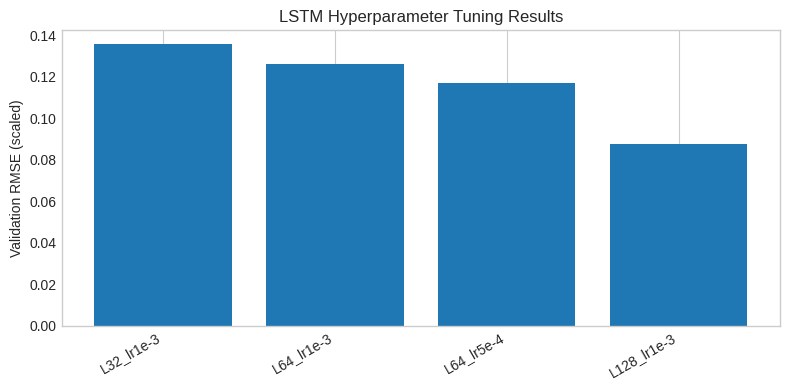

In [ ]:
# ==== Lightweight LSTM Hyperparameter Tuning ====

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

def build_lstm_model(units, lr, input_shape, dropout=0.2):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(units, return_sequences=True),
        layers.Dropout(dropout),
        layers.LSTM(units // 2),
        layers.Dropout(dropout),
        layers.Dense(units // 2, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="mse"
    )
    return model

input_shape = X_train.shape[1:]

param_grid = [
    {"name": "L32_lr1e-3",  "units": 32,  "lr": 1e-3, "batch_size": 64},
    {"name": "L64_lr1e-3",  "units": 64,  "lr": 1e-3, "batch_size": 64},
    {"name": "L64_lr5e-4",  "units": 64,  "lr": 5e-4, "batch_size": 64},
    {"name": "L128_lr1e-3", "units": 128, "lr": 1e-3, "batch_size": 64},
]

results = []

for cfg in param_grid:
    print(f"\nTraining config: {cfg['name']}")

    model = build_lstm_model(cfg["units"], cfg["lr"], input_shape)
    early = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=40,
        batch_size=cfg["batch_size"],
        callbacks=[early],
        verbose=0
    )

    # Validation RMSE on scaled targets
    y_val_pred_scaled = model.predict(X_val).reshape(-1)
    val_rmse_scaled = np.sqrt(mean_squared_error(y_val, y_val_pred_scaled))

    results.append({
        "name": cfg["name"],
        "units": cfg["units"],
        "lr": cfg["lr"],
        "batch_size": cfg["batch_size"],
        "best_val_loss": float(np.min(history.history["val_loss"])),
        "val_rmse_scaled": float(val_rmse_scaled),
        "epochs_run": len(history.history["loss"])
    })

# Convert to DataFrame for viewing
results_df = pd.DataFrame(results)
display(results_df)

# Plot validation RMSE for each config
plt.figure(figsize=(8, 4))
plt.bar(results_df["name"], results_df["val_rmse_scaled"])
plt.ylabel("Validation RMSE (scaled)")
plt.title("LSTM Hyperparameter Tuning Results")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


Best config from tuning:
Name:       L128_lr1e-3
Units:      128
LR:         0.001
Batch size: 64
Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 48s 75ms/step - loss: 0.1336 - mae: 0.2561 - val_loss: 0.0167 - val_mae: 0.0978
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 40s 73ms/step - loss: 0.0269 - mae: 0.1272 - val_loss: 0.0154 - val_mae: 0.0964
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - loss: 0.0192 - mae: 0.1074 - val_loss: 0.0113 - val_mae: 0.0841
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - loss: 0.0154 - mae: 0.0964 - val_loss: 0.0083 - val_mae: 0.0721
Epoch 5/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - loss: 0.0139 - mae: 0.0914 - val_loss: 0.0083 - val_mae: 0.0728
Epoch 6/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 81s 72ms/step - loss: 0.0121 - mae: 0.0851 - val_loss: 0.0070 - val_mae: 0.0660
Epoch 7/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - loss: 0.0108 - mae: 0.0807 - val_loss: 0.0079 - val_mae: 0.0714
Epoch 8/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - loss: 

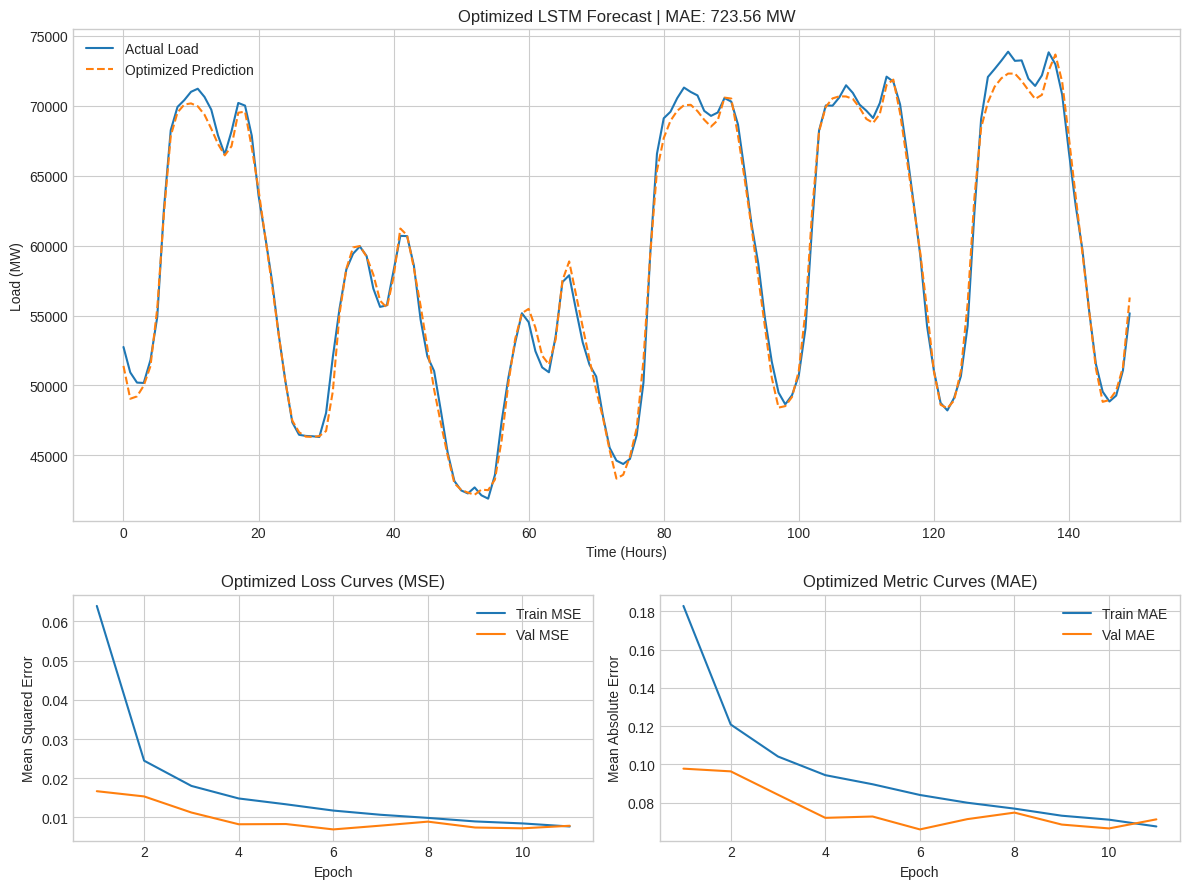

In [ ]:
# Choose the best configuration from the tuning results
best_row = results_df.loc[results_df["val_rmse_scaled"].idxmin()]
best_name = best_row["name"]
best_units = int(best_row["units"])
best_lr = float(best_row["lr"])
best_batch = int(best_row["batch_size"])

print("Best config from tuning:")
print(f"Name:       {best_name}")
print(f"Units:      {best_units}")
print(f"LR:         {best_lr}")
print(f"Batch size: {best_batch}")


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(42)

input_shape = X_train.shape[1:]

def build_lstm_for_final(units, lr, input_shape, dropout=0.2):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(units, return_sequences=True),
        layers.Dropout(dropout),
        layers.LSTM(units // 2),
        layers.Dropout(dropout),
        layers.Dense(units // 2, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=["mae"]          # track MAE as a metric
    )
    return model

optimized_lstm = build_lstm_for_final(best_units, best_lr, input_shape)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history_opt = optimized_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=best_batch,
    callbacks=[early_stopping],
    verbose=1
)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Helper if you don't already have it defined
def inverse_scale_load(y_scaled, scaler, target_idx):
    y_scaled = np.asarray(y_scaled).reshape(-1)
    zeros = np.zeros((len(y_scaled), scaler.n_features_in_))
    zeros[:, target_idx] = y_scaled
    inv = scaler.inverse_transform(zeros)
    return inv[:, target_idx]

# ---- Predictions on test set ----
y_test_pred_scaled = optimized_lstm.predict(X_test).reshape(-1)

y_test_inv = inverse_scale_load(y_test, scaler, target_idx)
y_pred_inv = inverse_scale_load(y_test_pred_scaled, scaler, target_idx)

test_mae_mw = mean_absolute_error(y_test_inv, y_pred_inv)
test_rmse_mw = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"Optimized LSTM – Test MAE (MW):  {test_mae_mw:.2f}")
print(f"Optimized LSTM – Test RMSE (MW): {test_rmse_mw:.2f}")

# ---- Build TCN-style combined figure ----
# history_opt.history has: 'loss', 'val_loss', 'mae', 'val_mae'
train_loss = history_opt.history["loss"]
val_loss = history_opt.history["val_loss"]
train_mae = history_opt.history["mae"]
val_mae = history_opt.history["val_mae"]
epochs = range(1, len(train_loss) + 1)

# Number of hours to show in top plot
N = 150

fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(2, 2, height_ratios=[2, 1])

# Top: Actual vs Predicted
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(y_test_inv[:N], label="Actual Load")
ax1.plot(y_pred_inv[:N], "--", label="Optimized Prediction")
ax1.set_xlabel("Time (Hours)")
ax1.set_ylabel("Load (MW)")
ax1.set_title(f"Optimized LSTM Forecast | MAE: {test_mae_mw:.2f} MW")
ax1.legend()
ax1.grid(True)

# Bottom-left: MSE curves
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(epochs, train_loss, label="Train MSE")
ax2.plot(epochs, val_loss, label="Val MSE")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Mean Squared Error")
ax2.set_title("Optimized Loss Curves (MSE)")
ax2.legend()
ax2.grid(True)

# Bottom-right: MAE curves
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(epochs, train_mae, label="Train MAE")
ax3.plot(epochs, val_mae, label="Val MAE")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Mean Absolute Error")
ax3.set_title("Optimized Metric Curves (MAE)")
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()



Starting GRU Optimization Experiment...
Testing Units: 32 | Val MAE: 0.07802
Testing Units: 64 | Val MAE: 0.06188
Testing Units: 128 | Val MAE: 0.06337
Optimization Complete. Best Configuration: 64 units

Training Best Multi-variate GRU Model (64 Units)...
Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.1577 - mae: 0.2841 - val_loss: 0.0206 - val_mae: 0.1108 - learning_rate: 0.0010
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0390 - mae: 0.1533 - val_loss: 0.0117 - val_mae: 0.0837 - learning_rate: 0.0010
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0267 - mae: 0.1276 - val_loss: 0.0091 - val_mae: 0.0734 - learning_rate: 0.0010
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0225 - mae: 0.1167 - val_loss: 0.0081 - val_mae: 0.0702 - learning_rate: 0.0010
Epoch 5/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0207 - mae: 0.1113 - val_loss: 0.0072 - val_mae: 0.0663 - learning_rate: 0.0010
Epoch 6/50
551/551 ━━━━━━━━━━━━━

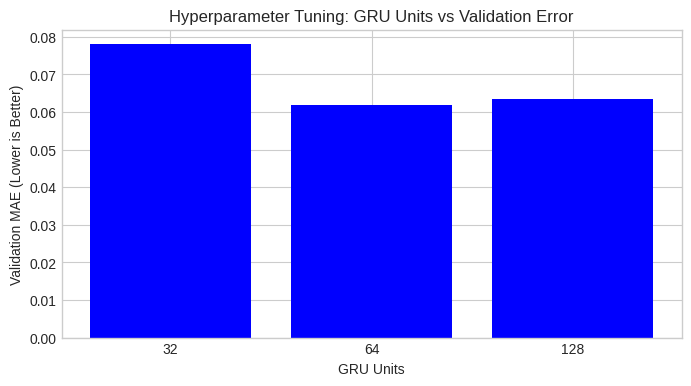

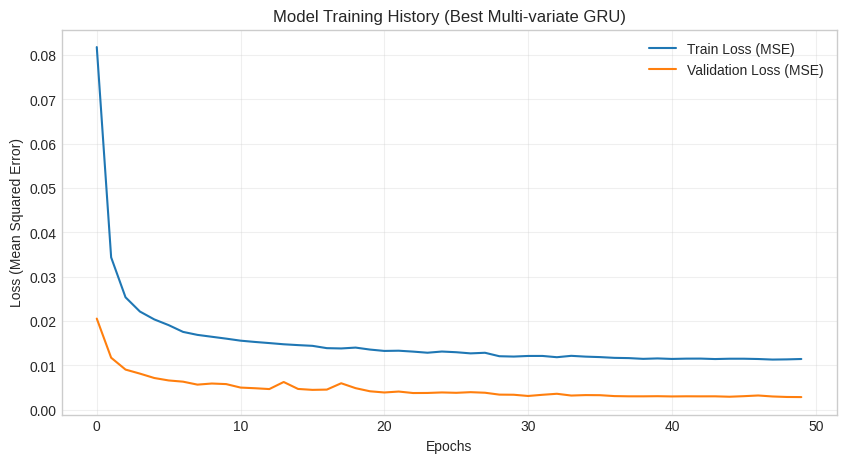

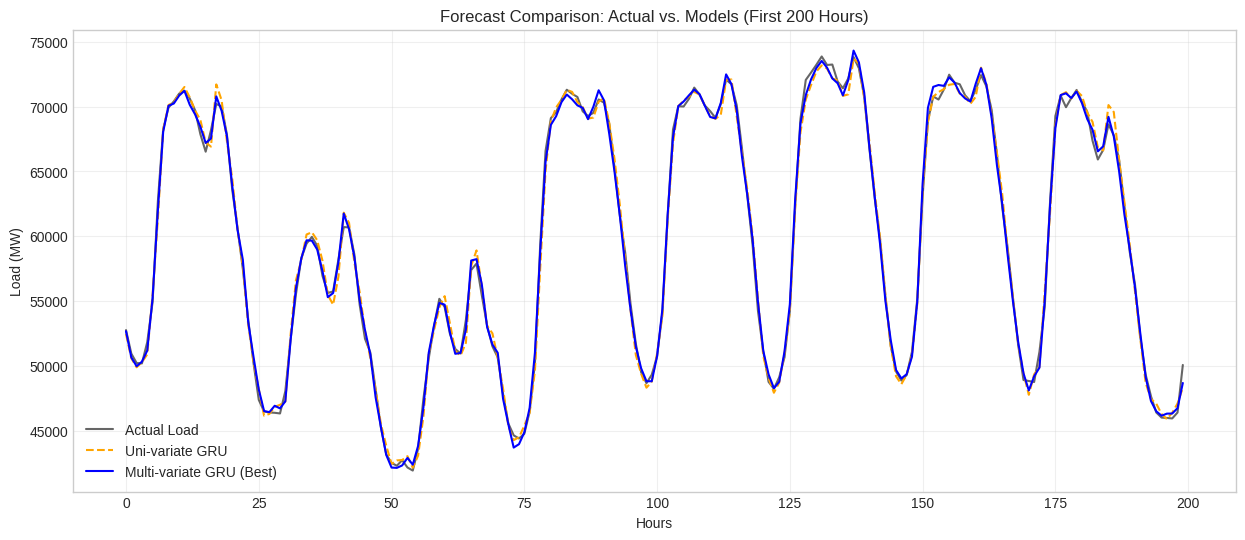

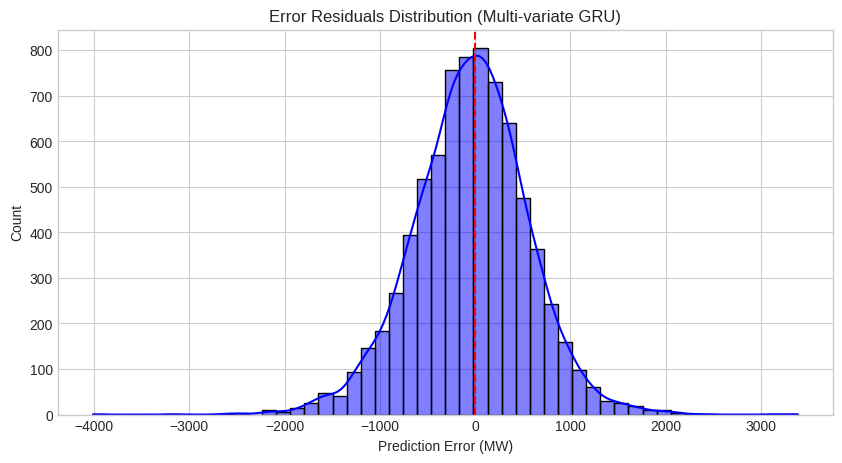

Mean Residual: -49.61 MW (Bias)


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Dynamically determine window size and feature count from the preprocessed data
# This ensures compatibility with the group's previous data loading steps
SEQ_LENGTH = X_train.shape[1]
N_FEATURES = X_train.shape[2]

# Helper function to generate sequences for the univariate baseline
# Defined locally to ensure availability in this cell scope
def create_sequences_local(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

# Hyperparameter Optimization Experiment
# Tests different GRU unit sizes to identify the architecture minimizing validation error
print("\nStarting GRU Optimization Experiment...")

def build_gru_model(input_shape, units=64, dropout=0.2):
    # Constructs a stacked GRU architecture with dropout for regularization
    model = Sequential([
        Input(shape=input_shape),
        GRU(units=units, return_sequences=True),
        Dropout(dropout),
        GRU(units=units // 2, return_sequences=False),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

unit_options = [32, 64, 128]
optimization_results = {}
best_mae = float('inf')
best_units = 64

for units in unit_options:
    model = build_gru_model((SEQ_LENGTH, N_FEATURES), units=units)

    # Train for a limited number of epochs to assess convergence speed
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=5,
        batch_size=64,
        verbose=0
    )

    val_mae = history.history['val_mae'][-1]
    optimization_results[str(units)] = val_mae
    print(f"Testing Units: {units} | Val MAE: {val_mae:.5f}")

    if val_mae < best_mae:
        best_mae = val_mae
        best_units = units

print(f"Optimization Complete. Best Configuration: {best_units} units")

# Train Best Multi-variate GRU Model
# Retrains the model using the optimal unit size found in the previous step
print(f"\nTraining Best Multi-variate GRU Model ({best_units} Units)...")

best_model = build_gru_model((SEQ_LENGTH, N_FEATURES), units=best_units)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
]

history_best = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# Uni-variate Baseline Training
# Trains a separate model using only the target variable (load) for comparison
print("\nTraining Uni-variate Baseline (Load Only)...")

# Extract the target column (index 0) from the scaled datasets
train_uni = train_scaled[:, 0:1]
val_uni = val_scaled[:, 0:1]
test_uni = test_scaled[:, 0:1]

X_train_u, y_train_u = create_sequences_local(train_uni, SEQ_LENGTH)
X_val_u, y_val_u = create_sequences_local(val_uni, SEQ_LENGTH)
X_test_u, y_test_u = create_sequences_local(test_uni, SEQ_LENGTH)

uni_model = build_gru_model((SEQ_LENGTH, 1), units=best_units)

uni_history = uni_model.fit(
    X_train_u, y_train_u,
    validation_data=(X_val_u, y_val_u),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=0
)

# Evaluation and Visualization
# Generate predictions for both models on the test set
pred_multi_scaled = best_model.predict(X_test)
pred_uni_scaled = uni_model.predict(X_test_u)

# Inverse transform predictions to original scale (Megawatts)
# Uses a dummy array to match the scaler's expected input shape
def inverse_transform_target(pred_scaled, scaler, n_features):
    dummy = np.zeros((len(pred_scaled), n_features))
    dummy[:, 0] = pred_scaled.flatten()
    return scaler.inverse_transform(dummy)[:, 0]

# Perform inverse transformation
y_test_real = inverse_transform_target(y_test.reshape(-1, 1), scaler, N_FEATURES)
pred_multi_real = inverse_transform_target(pred_multi_scaled, scaler, N_FEATURES)
pred_uni_real = inverse_transform_target(pred_uni_scaled, scaler, N_FEATURES)

# Calculate final error metrics (MAE and RMSE)
mae_m = mean_absolute_error(y_test_real, pred_multi_real)
rmse_m = np.sqrt(mean_squared_error(y_test_real, pred_multi_real))
mae_u = mean_absolute_error(y_test_real, pred_uni_real)
rmse_u = np.sqrt(mean_squared_error(y_test_real, pred_uni_real))

print("\nFinal Results Comparison:")
print(f"Uni-variate GRU  : MAE={mae_u:.2f} MW | RMSE={rmse_u:.2f} MW")
print(f"Multi-variate GRU: MAE={mae_m:.2f} MW | RMSE={rmse_m:.2f} MW")

improvement = ((mae_u - mae_m) / mae_u) * 100
print(f"Improvement: {improvement:.2f}%")

# Plot 1: Optimization Results (Bar Chart)
# Visualizes the validation error across different unit configurations
plt.figure(figsize=(8, 4))
plt.bar(optimization_results.keys(), optimization_results.values(), color=['blue', 'blue', 'blue'])
plt.title('Hyperparameter Tuning: GRU Units vs Validation Error')
plt.xlabel('GRU Units')
plt.ylabel('Validation MAE (Lower is Better)')
plt.show()

# Plot 2: Training History (Loss Curves)
# Shows the convergence of training and validation loss to verify no overfitting
plt.figure(figsize=(10, 5))
plt.plot(history_best.history['loss'], label='Train Loss (MSE)')
plt.plot(history_best.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Model Training History (Best Multi-variate GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot 3: Forecast Comparison
# Visual comparison of the first 200 hours of predictions against actual load
plt.figure(figsize=(15, 6))
slice_range = slice(0, 200)
plt.plot(y_test_real[slice_range], label='Actual Load', color='black', alpha=0.6)
plt.plot(pred_uni_real[slice_range], label='Uni-variate GRU', color='orange', linestyle='--')
plt.plot(pred_multi_real[slice_range], label='Multi-variate GRU (Best)', color='blue')
plt.title('Forecast Comparison: Actual vs. Models (First 200 Hours)')
plt.ylabel('Load (MW)')
plt.xlabel('Hours')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot 4: Residual Analysis (Histogram)
# Displays the distribution of prediction errors to identify potential bias
errors = y_test_real - pred_multi_real
plt.figure(figsize=(10, 5))
sns.histplot(errors, kde=True, color='blue', bins=50)
plt.title('Error Residuals Distribution (Multi-variate GRU)')
plt.xlabel('Prediction Error (MW)')
plt.axvline(x=0, color='red', linestyle='--')
plt.show()

print(f"Mean Residual: {np.mean(errors):.2f} MW (Bias)")